I also played around with embeddings, but this didn't go anywhere TODO

In [23]:
from dotenv import load_dotenv
import os
import requests
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
import plotly.express as px
import matplotlib.pyplot as plt

In [24]:
# GLOBALS
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [27]:
df = pd.read_csv('./datasets/malicious-phish.csv', names=['URL', 'Classification'])
load_dotenv()

True

In [ ]:
df = df.iloc[1:].reset_index(drop=True) # drops the first row which is a header from the csv

In [ ]:
df.head()

,URL,Classification
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


format df for embeddings

In [ ]:
urlList = df['URL'].tolist()

# Code to generate embeddings:

Did this 1000 at at time as a test:

In [ ]:
def getEmbeddings(df, test_size=1000):
    test_size = min(test_size, len(df)) # ensure test is not larger than og df
    test_indices = random.sample(range(len(df)), test_size)
    test_urls = df.loc[test_indices, 'URL'].tolist()
    api_url = "https://api.openai.com/v1/embeddings"
    headers = {
        "Authorization": "Bearer " + OPENAI_API_KEY,
        "Content-Type": "application/json",
    }
    chunk_size = 20  # split into chunks
    index_to_embedding = {}  # keep mapping index to embedding
    for i in range(0, len(test_urls), chunk_size):
        chunk_indices = test_indices[i:i+chunk_size]
        chunk_urls = test_urls[i:i+chunk_size]
        data = {
            "model": "text-embedding-3-large",
            "input": chunk_urls
        }
        response = requests.post(api_url, headers=headers, json=data)
        if response.status_code == 200:
            for index, embedding in zip(chunk_indices, response.json()['data']):
                index_to_embedding[index] = embedding['embedding']
        else:
            print("Error:", response.text)
            break
    return index_to_embedding

In [ ]:
test_embeddings = getEmbeddings(df) # get embeddings for 1000 random urls

In [ ]:
df['Embedding'] = np.nan
def apply_embeddings(row, embeddings_dict):
    if row.name in embeddings_dict:
        return embeddings_dict[row.name]
    else:
        return np.nan
df['Embedding'] = df.apply(apply_embeddings, axis=1, embeddings_dict=test_embeddings)

In [ ]:
df_with_embeddings = df.dropna(subset=['Embedding']).reset_index(drop=True)

In [ ]:
df_with_embeddings.head()

,URL,Classification,Embedding
0,http://torcache.net/torrent/3B72AAC22AE198BDF5...,benign,"[-0.0041858885, 0.0078063924, -0.0054052114, 0..."
1,realtor.com/property-search/Bartlett_TN/Carrie...,benign,"[0.015922341, 0.019420432, 0.0028363348, 0.016..."
2,mylife.com/sylvainblouin,benign,"[-1.1662287e-05, -0.004703661, -0.013044295, 0..."
3,dictionary.sensagent.com/julie/fr-fr/,benign,"[-0.0012197733, 0.036611434, 0.0021642316, -0...."
4,http://www.dovehouse.us/component/content/arti...,defacement,"[-0.05250427, 0.0030367628, -0.0022492441, 0.0..."



High-dimensional embeddings are hard to visualize directly, so you'll use a technique like PCA (Principal Component Analysis) or t-SNE for dimensionality reduction.

/var/folders/mc/95_crr254419klxgq2zx3j780000gn/T/ipykernel_67528/24374797.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_classifications))


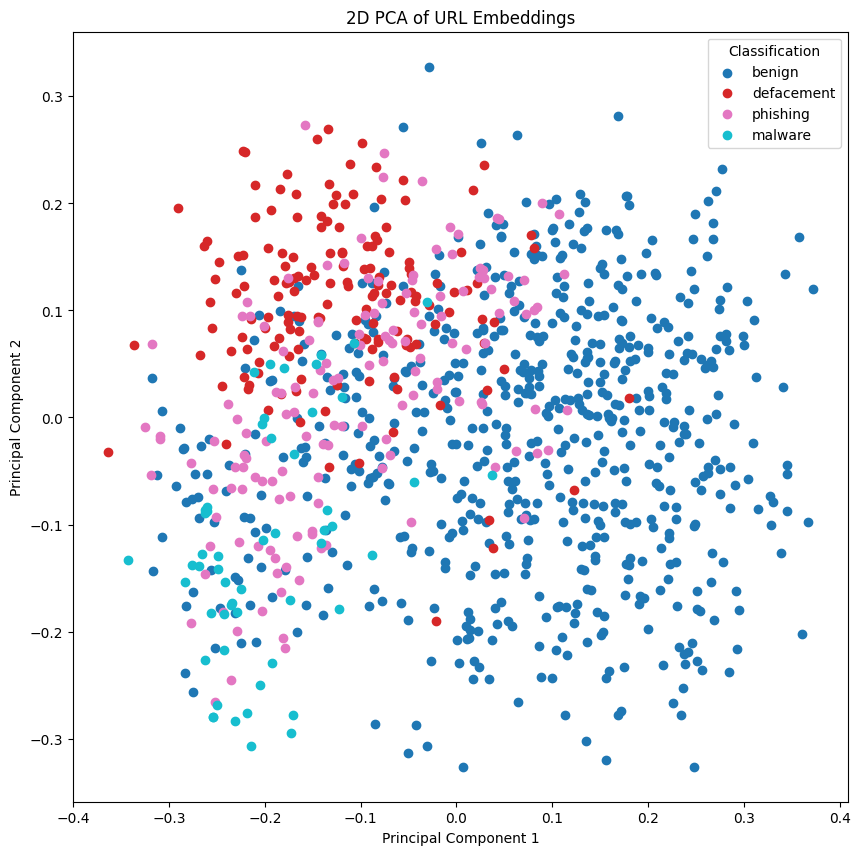

In [ ]:
embeddings_array = np.stack(df_with_embeddings['Embedding'].values)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 10))

unique_classifications = df_with_embeddings['Classification'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_classifications))

for i, classification in enumerate(unique_classifications):
    idx = df_with_embeddings['Classification'] == classification
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=classification, color=colors(i))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of URL Embeddings')
plt.legend(title='Classification')
plt.show()

Create an interactive scatter with plotly to see the PCA:

In [ ]:
embeddings_array = np.stack(df_with_embeddings['Embedding'].values)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)
reduced_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2'])
reduced_df['Classification'] = df_with_embeddings['Classification'].values
fig = px.scatter(reduced_df, x='PC1', y='PC2', color='Classification', 
                 hover_data=['Classification'], title='2D PCA of URL Embeddings')
fig.show()

1. Cluster analysis
2. Anomaly detection
3. Build a classifier model
4. Dimensionality reduction further by t-SNE or UMAP

In [ ]:
embeddings_array = np.stack(df_with_embeddings['Embedding'].values)
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_array)

reduced_df = pd.DataFrame(reduced_embeddings, columns=['PC1', 'PC2', 'PC3'])
reduced_df['Classification'] = df_with_embeddings['Classification'].values

fig = px.scatter_3d(reduced_df, x='PC1', y='PC2', z='PC3', color='Classification',
                    hover_data=['Classification'], title='3D PCA of URL Embeddings')
fig.show()